# Resitive Crack FFT Modeling
---

## Page Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Packages
import os
import sys
import copy
import time
import tabulate
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

In [3]:
from app.models import Classifier
from app.utils import ImageWrapper 
from app.transforms import FFT, IFFT, CreateOnesMask, Butterworth
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure
from app.custom import RemoveBusBars, Orient, HighlightFrontGrid

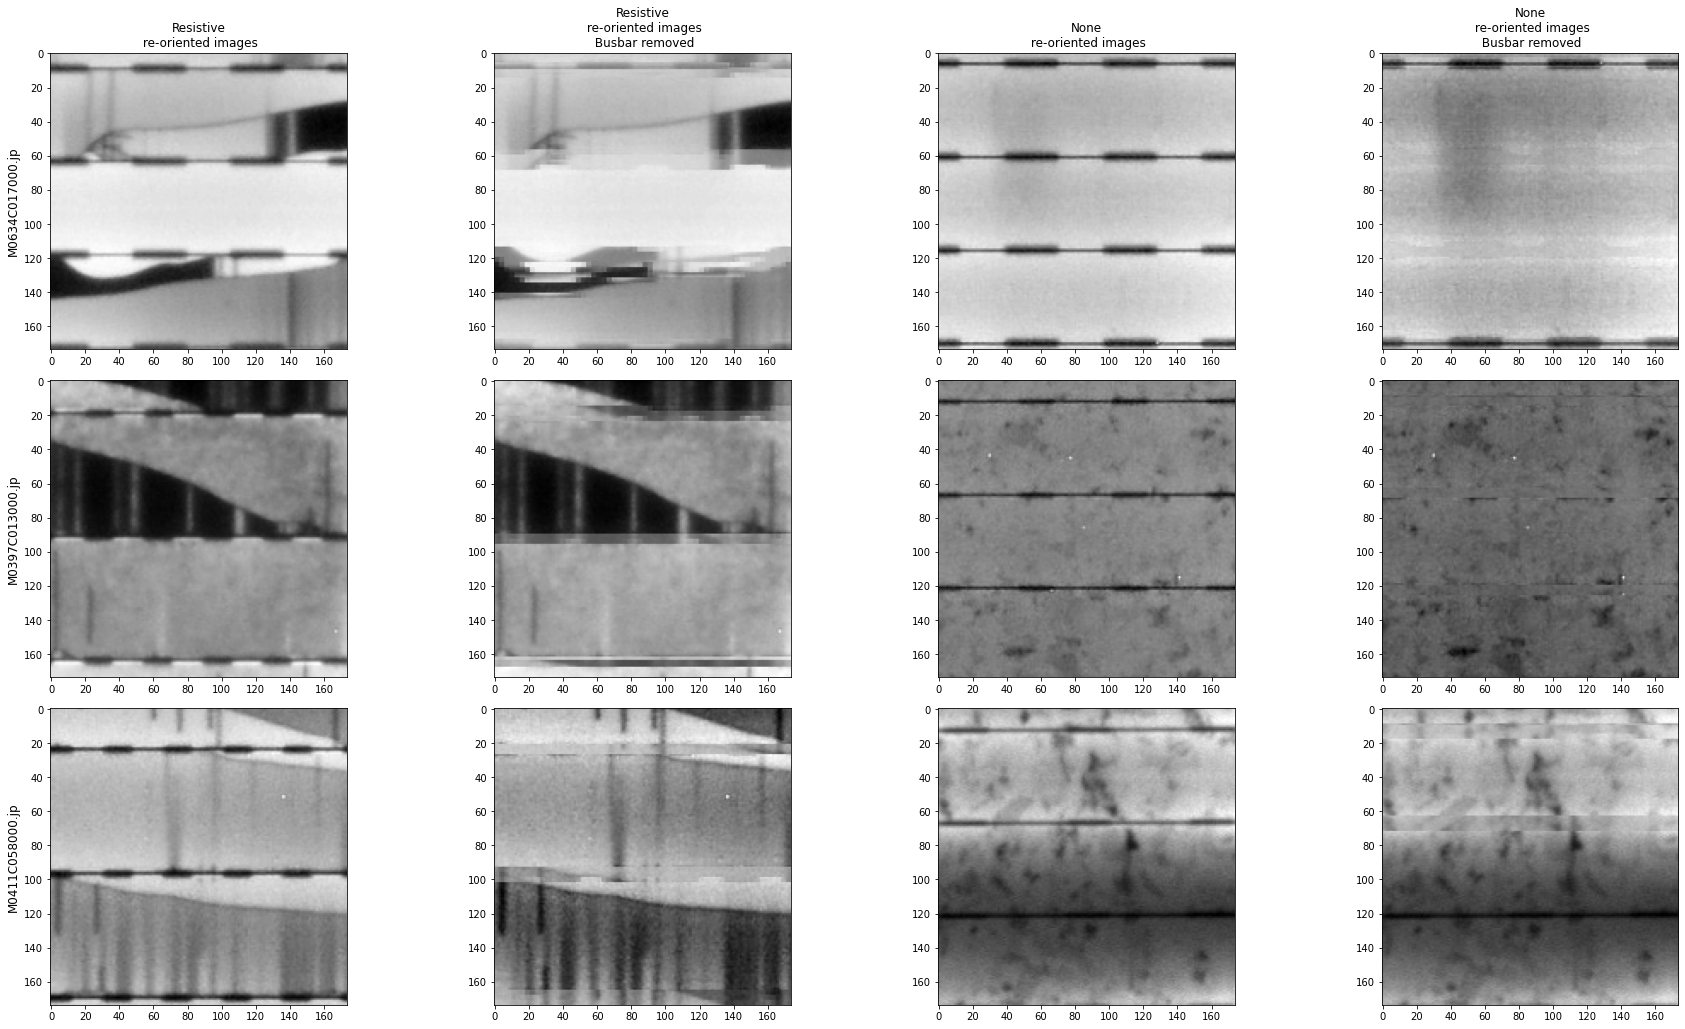

In [4]:
# Load 10 examples and name the category for it. Category is like a title for images
n_samples = 500
seed = 1234
defect = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='Resistive') << n_samples))
defect.category = 'Resistive'
clean = (DefectViewer(row_chop=25, col_chop=25) << (ImageLoader(defect_class='None') << n_samples))
clean.category = 'None'

oriented_defect = Orient(num_jobs=20) << defect
oriented_clean = Orient(num_jobs=20) << clean
nobus_defect = RemoveBusBars() << oriented_defect
nobus_clean = RemoveBusBars() << oriented_clean

# View both the defect and the clean class
# I am using a tuple in this case as defect and clean are ImageWrapper objects
# Show random 5 out of the 10 images. Using the seed will ensure the same 5 are shown everytime
_ = Show(num_images=3, seed=seed) << nobus_defect + nobus_clean

## FFT Transforms
---

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
fft_images = FFT(dim=2) << nobus_defect
amplitued = ~(fft_images[1])
fig = plt.figure()
fig.set_size_inches(7,7)
plt.imshow(amplitued[0], cmap='gray', vmin=np.min(amplitued[0]), vmax=np.max(amplitued[0]))
plt.show()

In [ ]:
# _ = Show(do_show=True, num_images=10) << fft_images

In [ ]:
# defect_sigmoid = Exposure('sigmoid', inverse=True) << nobus_defect
# cm = CreateOnesMask(~nobus_defect[-1])
# # mask = cm.horizontal_from_center(left_width=10, right_width=10, height=3, val=0)
# mask = cm.vertical_from_center(top_height=100, bottom_height=1000, width=1000, val=1)
# # mask = cm.center_circle(radius=100)
# # _ = Show(do_show=True, num_images=10) << (IFFT(mask) << (Show(do_show=False, num_images=10) << (FFT(dim=2) << defect_sigmoid)))

# _ = Show(do_show=True, num_images=10) << (IFFT(mask) << (FFT(dim=2) << nobus_defect[-1]))

In [ ]:
images_ifft = (IFFT() << fft_images)
_ = Show(do_show=True, num_images=10) << test

In [ ]:
G = np.fft.ifftshift(amplitued[0])
f = np.abs(np.fft.ifft(G))
fig = plt.figure()
fig.set_size_inches(7,7)
plt.imshow(g, cmap='gray', vmin=np.min(amplitued[0]), vmax=np.max(amplitued[0]))
plt.show()

In [ ]:
# Butterworh Lowpass Filter
def butterworth_low(f, D0, n):
    M,N = f.shape
    H = np.zeros((M,N), dtype=np.float32)

    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = 1 / (1 + (D/D0)**(2*n))
    return H

# Butterworth highpass filter
def butterworth_high(f, D0, n):
    M,N = f.shape
    H = np.zeros((M,N), dtype=np.float32)

    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = 1 / (1 + (D0/D)**(2*n))
    return H

# Butterworth Bandpass
def butterworth_band(f, D0_low, D0_high, n_low, n_high):
    high = butterworth_high(f, D0_high, n_high)
    low = butterworth_low(f, D0_low, n_low)
    band = low + high
    return band
    

In [ ]:
# x=(~defect)[3]
q = ~(nobus_defect)[1]
x = q[10]
fig = plt.figure()
fig.set_size_inches(7,7)
plt.imshow(x, cmap='gray')
plt.show()

In [ ]:
F = np.fft.fft2(x)
Fshift = np.fft.fftshift(F)

# mask = butterworth_low(Fshift, 3, 1)
# mask = butterworth_high(Fshift, 15, 1)
mask = butterworth_band(Fshift, 3, 15, 1, 1)

Gshift = np.multiply(mask, Fshift)

G = np.fft.ifftshift(Gshift)
f = np.abs(np.fft.ifft2(G))

fig.set_size_inches(7,7)
plt.imshow(f, cmap='gray')
plt.show()

##  Bring Into App Codebase
---

In [5]:
# btw = Butterworth((~(nobus_defect)[1]))
x = nobus_defect[-1]
btw = Butterworth(((~x)[0]))
btw.bandpass(3, 15, 1, 1)

/home/dan/Documents/git/w281_finalproject_solascan/notebooks/../app/transforms.py:453: RuntimeWarning: divide by zero encountered in double_scalars
  H[u,v] = 1 / (1 + (D0_high/D)**(2*n_high))


array([[0.9859486 , 0.9857887 , 0.98562694, ..., 0.9854635 , 0.98562694,
        0.9857887 ],
       [0.9857887 , 0.9856251 , 0.98545957, ..., 0.98529226, 0.98545957,
        0.9856251 ],
       [0.98562694, 0.98545957, 0.9852902 , ..., 0.985119  , 0.9852902 ,
        0.98545957],
       ...,
       [0.9854635 , 0.98529226, 0.985119  , ..., 0.9849437 , 0.985119  ,
        0.98529226],
       [0.98562694, 0.98545957, 0.9852902 , ..., 0.985119  , 0.9852902 ,
        0.98545957],
       [0.9857887 , 0.9856251 , 0.98545957, ..., 0.98529226, 0.98545957,
        0.9856251 ]], dtype=float32)

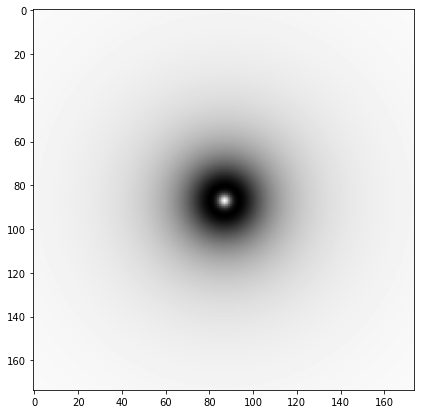

In [10]:
mask = btw.bandpass(3, 15, 1, 1)

fig = plt.figure()
fig.set_size_inches(7,7)
plt.imshow(mask, cmap='gray')
plt.show()

In [43]:
# images = Show(do_show=True) << (IFFT(mask)
f = FFT(dim=2, axis=(-2, -1)) << nobus_defect
iff = IFFT(mask) << f 

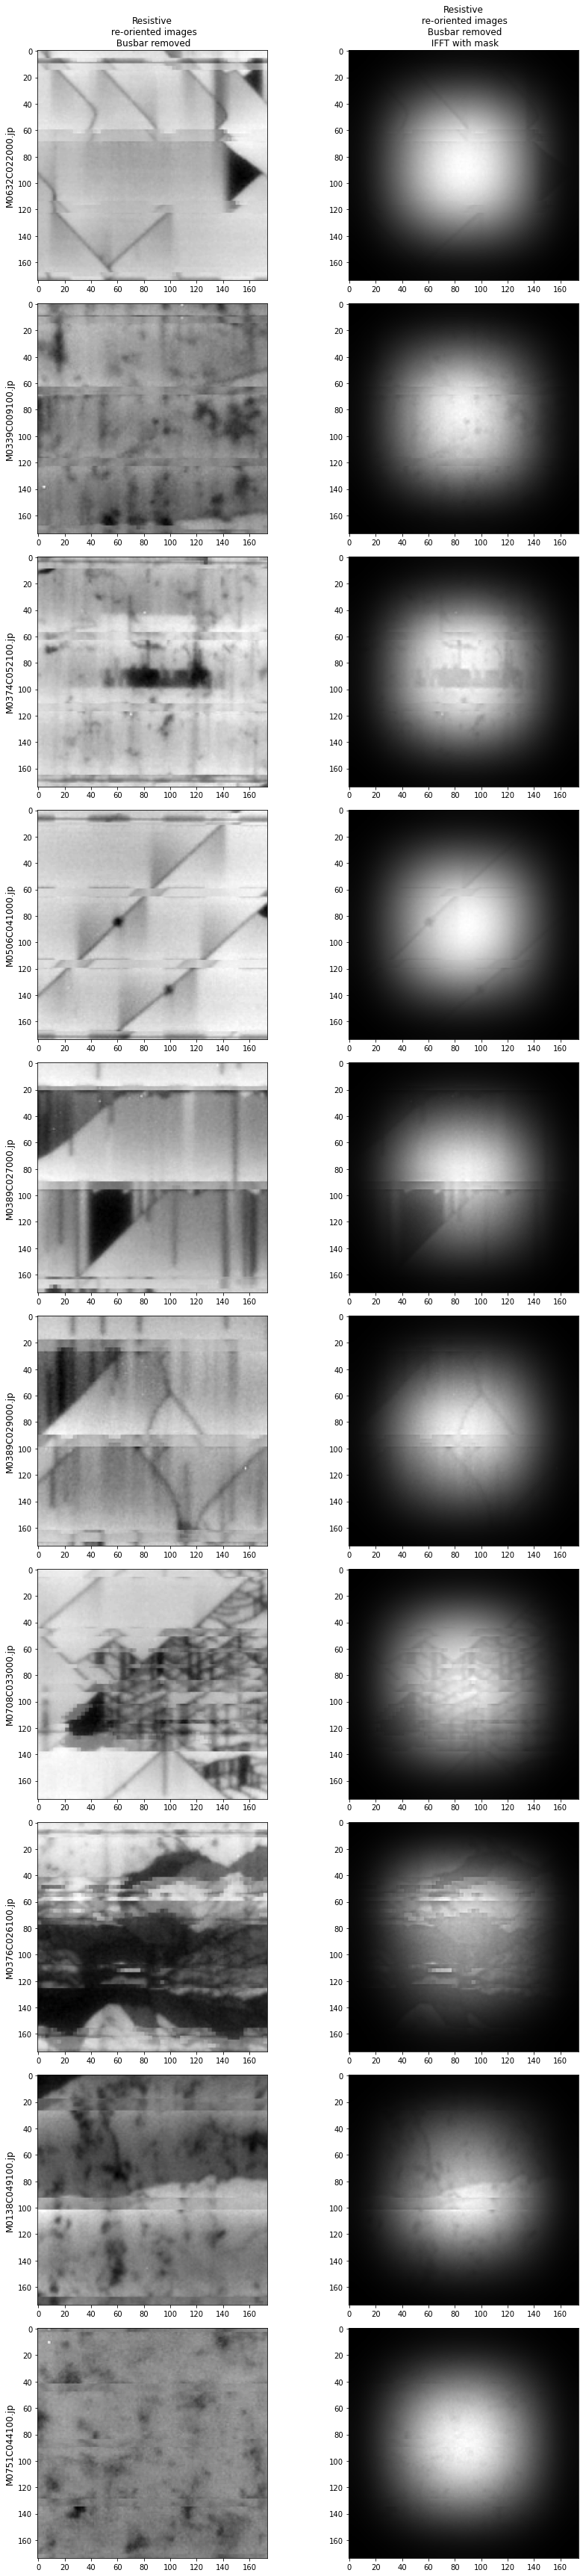

In [44]:
_ = Show(do_show=True, num_images=10) << iff

## Classifiers with Just Band Pass
---

In [50]:
%%time
# 1. Base model on raw data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7080405126085159
          Pred 0    Pred 1
------  --------  --------
True 0        64        18
True 1        43        75
CPU times: user 2.46 s, sys: 319 ms, total: 2.78 s
Wall time: 670 ms


/home/dan/anaconda3/envs/w281_final_project/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [51]:
%%time
# 2. HOG on RAW data
model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100, 'num_jobs': 20}
cla = Classifier(nobus_defect[-1], nobus_clean[-1], LogisticRegression, HOG)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

0.7806945018602729
          Pred 0    Pred 1
------  --------  --------
True 0        78         4
True 1        46        72
CPU times: user 2.62 s, sys: 1.57 s, total: 4.19 s
Wall time: 4.93 s


In [53]:
%%time
# 3. Base model on bandfilterd
band_defect = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << nobus_defect)
band_clean = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << nobus_clean)

model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], nobus_clean[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

1.0
          Pred 0    Pred 1
------  --------  --------
True 0        82         0
True 1         0       118
CPU times: user 5.32 s, sys: 999 ms, total: 6.32 s
Wall time: 4.2 s


In [54]:
%%time
# 4. Base model on raw
band_defect = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << defect)
band_clean = IFFT(mask) << (FFT(dim=2, axis=(-2, -1)) << clean)

model_params = {'penalty': 'l2', 'seed': 14376, 'pca_dims': 100}
cla = Classifier(band_defect[-1], nobus_clean[-1], LogisticRegression, None)
score = cla.fit(**model_params)
print(score)

# Misclassified
conf, out = cla.misclassified()
print(tabulate.tabulate([['True 0', conf[0, 0], conf[0, 1]], ['True 1', conf[1, 0], conf[1, 1]]], headers=['', 'Pred 0', 'Pred 1']))

1.0
          Pred 0    Pred 1
------  --------  --------
True 0        82         0
True 1         0       118
CPU times: user 5.35 s, sys: 1.11 s, total: 6.45 s
Wall time: 4.32 s
